# Setting model requirements

## Load library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from Models import DenoiseAutoEncoder_DTG, CNNModel, inverse_transform, fit_quality, Cal_Composition

## Torch device setting (GPU or CPU)

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    is_cuda = True
else:
    device = torch.device('cpu')
    is_cuda = False
print('Using Pytorch version:', torch.__version__, 'CUDA versoin:', torch.version.cuda, "Device:", device)

Using Pytorch version: 2.2.0 CUDA versoin: 12.1 Device: cuda


## Loading codes and model parameters

In [3]:
# Denoise AutoEncoder
DAE_DTG = torch.load('Denoise_AutoEncoder_DTG_dt.pt')
checkpoint_DTG = torch.load('DAE_DTG_with_scalers_dt.pt')
DAE_DTG.load_state_dict(checkpoint_DTG['model_state_dict'])
scaler_DTG_X = checkpoint_DTG['scaler_DTG_X']
scaler_DTG_Y = checkpoint_DTG['scaler_DTG_Y']

scaler_params = torch.load('scaler_params.pth')
scaler_param_H_1 = scaler_params['scaler_param_H_1']
scaler_param_H_2 = scaler_params['scaler_param_H_2']
scaler_param_C_1 = scaler_params['scaler_param_C_1']
scaler_param_C_2 = scaler_params['scaler_param_C_2']
scaler_param_L_1 = scaler_params['scaler_param_L_1']
scaler_param_L_2 = scaler_params['scaler_param_L_2']

model = CNNModel(NoOfFilter=30, dropout_prob=0.0).to(device)
model.load_state_dict(torch.load('best_DTG&HR_Conv1D(10-40Kmin).pt'))

checkpoint_scaler = torch.load('model_scalers_dt.pt')
scaler_Curve = checkpoint_scaler['scaler_Curve']
scaler_RateConst = checkpoint_scaler['scaler_RateConst']

c:\Users\KHY\anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Load experimental TGA data

SampleDTG_raw_scaled.shape: (4, 2250)


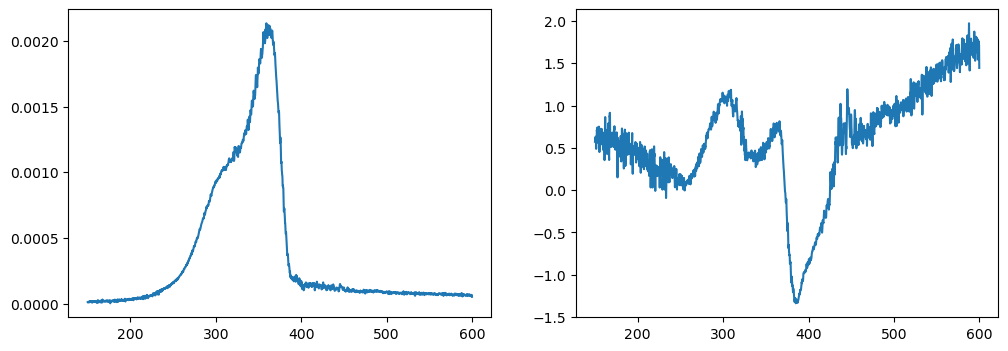

In [4]:
SampleData_WP = pd.read_excel('./Experimental TGA data for biomass samples.xlsx', sheet_name='Wood pellet', header=None, engine='openpyxl').to_numpy()[1:2251, 2]
SampleData_HC = pd.read_excel('./Experimental TGA data for biomass samples.xlsx', sheet_name='Hinoki', header=None, engine='openpyxl').to_numpy()[1:2251, 2]
SampleData_PW = pd.read_excel('./Experimental TGA data for biomass samples.xlsx', sheet_name='Pine', header=None, engine='openpyxl').to_numpy()[1:2251, 2]
SampleData_BW = pd.read_excel('./Experimental TGA data for biomass samples.xlsx', sheet_name='Birch', header=None, engine='openpyxl').to_numpy()[1:2251, 2]

HC, PW, BW, WP = 0, 1, 2, 3

SampleData_WP = np.expand_dims(SampleData_WP, axis = 1)
SampleData_HC = np.expand_dims(SampleData_HC, axis = 1)
SampleData_PW = np.expand_dims(SampleData_PW, axis = 1)
SampleData_BW = np.expand_dims(SampleData_BW, axis = 1)

SampleData_np = np.concatenate([SampleData_HC, SampleData_PW, SampleData_BW, SampleData_WP], axis = 1)
SampleData_np = SampleData_np.transpose()

temp = np.arange(150, 600, 0.2)
HeatingRate = np.zeros_like(SampleData_np)             
HeatingRate[:HeatingRate.shape[0]] = 10/60    # HR = 10 K/min = 10/60 K/s
SampleDTG_raw = SampleData_np/100 #Unit conversion: wt.%/s -> 1/s

SampleDTG_raw_scaled = scaler_DTG_X.transform(SampleDTG_raw)

print("SampleDTG_raw_scaled.shape:", SampleDTG_raw_scaled.shape)
#데이터 확인
sample = WP
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(temp, SampleDTG_raw[sample, :])
plt.subplot(1,2,2)
plt.plot(temp, SampleDTG_raw_scaled[sample, :])
plt.show()

## Removal of noise in raw data by Denoise AutoEncoder (DAE)

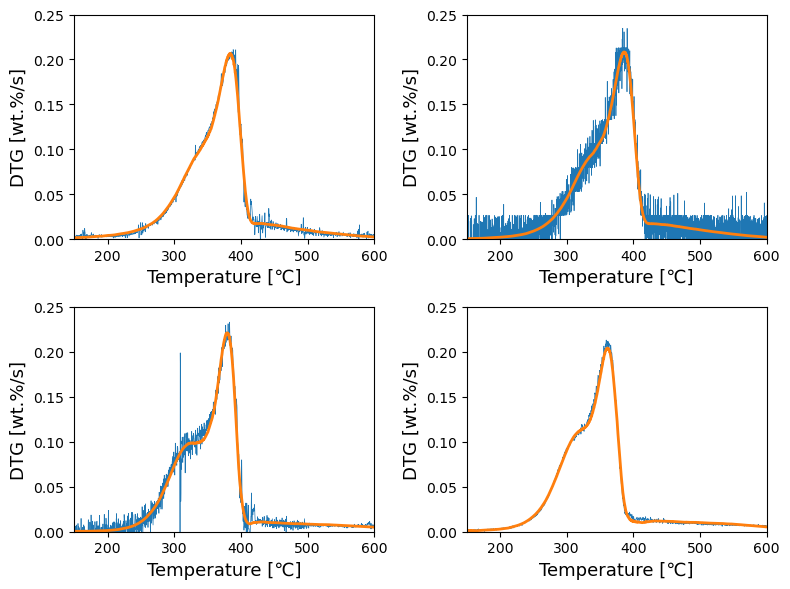

In [5]:
DAE_DTG.eval()
SampleDTG_raw_scaled = SampleDTG_raw_scaled.reshape([SampleDTG_raw_scaled.shape[0], 1, SampleDTG_raw_scaled.shape[1]])
SampleDTG_raw_tensor_scaled = torch.tensor(SampleDTG_raw_scaled, dtype=torch.float32).to(device)
with torch.no_grad():
    SampleDTG_restored_scaled_tensor = DAE_DTG(SampleDTG_raw_tensor_scaled).to(device)

SampleDTG_restored_scaled = SampleDTG_restored_scaled_tensor.cpu().numpy()
SampleDTG_raw_scaled = SampleDTG_raw_scaled.reshape([SampleDTG_raw_scaled.shape[0], SampleDTG_raw_scaled.shape[2]])
SampleDTG_restored_scaled = SampleDTG_restored_scaled.reshape([SampleDTG_restored_scaled.shape[0], SampleDTG_restored_scaled.shape[2]])
#inverse transform
SampleDTG_restored = scaler_DTG_Y.inverse_transform(SampleDTG_restored_scaled)
dt=0.2/(10/60)
alpha = np.zeros([SampleDTG_restored.shape[0], SampleDTG_restored.shape[1]])
for i in range(SampleDTG_restored.shape[1]-1):
    alpha[0, i+1] = alpha[0, i] + SampleDTG_restored[0, i] * dt

SampleDTG_restored /= alpha[0, -1]
SampleDTG_restored_scaled = scaler_DTG_X.transform(SampleDTG_restored)

# Plot raw and denoised DTG curves
plt.figure(figsize = (8, 6))

plt.subplot(2,2,1)
plt.plot(temp, SampleDTG_raw[HC, :]*100, lw=0.5)
plt.plot(temp, SampleDTG_restored[HC, :]*100, lw=2)
plt.xlabel("Temperature [℃]", fontsize=13)
plt.ylabel("DTG [wt.%/s]", fontsize=13)
plt.xlim(150, 600)
plt.ylim(0, 0.25)

plt.subplot(2,2,2)
plt.plot(temp, SampleDTG_raw[PW, :]*100, lw=0.5)
plt.plot(temp, SampleDTG_restored[PW, :]*100, lw=2)
plt.xlabel("Temperature [℃]", fontsize=13)
plt.ylabel("DTG [wt.%/s]", fontsize=13)
plt.xlim(150, 600)
plt.ylim(0, 0.25)

plt.subplot(2,2,3)
plt.plot(temp, SampleDTG_raw[BW, :]*100, lw=0.5)
plt.plot(temp, SampleDTG_restored[BW, :]*100, lw=2)
plt.xlabel("Temperature [℃]", fontsize=13)
plt.ylabel("DTG [wt.%/s]", fontsize=13)
plt.xlim(150, 600)
plt.ylim(0, 0.25)

plt.subplot(2,2,4)
plt.plot(temp, SampleDTG_raw[WP, :]*100, lw=0.5)
plt.plot(temp, SampleDTG_restored[WP, :]*100, lw=2)
plt.xlabel("Temperature [℃]", fontsize=13)
plt.ylabel("DTG [wt.%/s]", fontsize=13)
plt.xlim(150, 600)
plt.ylim(0, 0.25)

plt.tight_layout()
plt.show()

## Derivation of pyrolysis kinetics using 1D-CNN regression model

In [6]:
SampleData = np.concatenate([SampleDTG_restored, SampleDTG_raw, HeatingRate], axis=1)

SampleData_scaled = scaler_Curve.transform(SampleData)
SampleDTG_scaled = SampleData_scaled[:, :2250]
SampleHR_scaled = SampleData_scaled[:, 4500:]
SampleDTG_scaled = SampleDTG_scaled.reshape((SampleDTG_scaled.shape[0], 1, SampleDTG_scaled.shape[1]))
SampleHR_scaled = SampleHR_scaled.reshape((SampleHR_scaled.shape[0], 1, SampleHR_scaled.shape[1]))

SampleDTG_tensor = torch.tensor(SampleDTG_scaled, dtype=torch.float32).to(device)
HeatingRate_tensor = torch.tensor(SampleHR_scaled, dtype=torch.float32).to(device)
SampleRate_tensor = torch.cat([SampleDTG_tensor, HeatingRate_tensor], axis=1).to(device)

model.eval()

with torch.no_grad():
    SampleParameters_scaled = model(SampleRate_tensor)
    
SampleParameters_scaled = SampleParameters_scaled.cpu().numpy()

# unscaling the predicted values
A_H_pred_smp = inverse_transform(SampleParameters_scaled[:, 0], scaler_param_H_1[0],scaler_param_H_2[0], scaler_type='StandardScaler')
E_H_pred_smp = inverse_transform(SampleParameters_scaled[:, 1], scaler_param_H_1[1],scaler_param_H_2[1], scaler_type='StandardScaler')
n_H_pred_smp = inverse_transform(SampleParameters_scaled[:, 2], scaler_param_H_1[2],scaler_param_H_2[2], scaler_type='StandardScaler')
c_H_pred_smp = inverse_transform(SampleParameters_scaled[:, 3], scaler_param_H_1[3],scaler_param_H_2[3], scaler_type='StandardScaler')

A_L_pred_smp = inverse_transform(SampleParameters_scaled[:, 6], scaler_param_L_1[0], scaler_param_L_2[0], scaler_type='StandardScaler')
E_L_pred_smp = inverse_transform(SampleParameters_scaled[:, 7], scaler_param_L_1[1], scaler_param_L_2[1], scaler_type='StandardScaler')
c_L_pred_smp = inverse_transform(SampleParameters_scaled[:, 8], scaler_param_L_1[2], scaler_param_L_2[2], scaler_type='StandardScaler')

A_C_pred_smp = inverse_transform(SampleParameters_scaled[:, 4], scaler_param_C_1[0], scaler_param_C_2[0], scaler_type='StandardScaler')
E_C_pred_smp = inverse_transform(SampleParameters_scaled[:, 5], scaler_param_C_1[1], scaler_param_C_2[1], scaler_type='StandardScaler')
c_C_pred_smp = 1-c_H_pred_smp-c_L_pred_smp

RateConst_pred_smp = np.concatenate([A_H_pred_smp.reshape(-1,1), E_H_pred_smp.reshape(-1,1), n_H_pred_smp.reshape(-1,1), c_H_pred_smp.reshape(-1,1),
                                 A_C_pred_smp.reshape(-1,1), E_C_pred_smp.reshape(-1,1), c_C_pred_smp.reshape(-1,1),
                                 A_L_pred_smp.reshape(-1,1), E_L_pred_smp.reshape(-1,1), c_L_pred_smp.reshape(-1,1)], axis=1)

V_i = np.array([RateConst_pred_smp[:, 3], RateConst_pred_smp[:, 6], RateConst_pred_smp[:, 9]]).transpose()
C_i = Cal_Composition(V_i)
print(RateConst_pred_smp)
print('-------------------------------------------------------')
print("Lignocellulosic compositon:")
print("Hemicellulose", "Cellulose", "Lignin")
print(C_i)

[[ 7.60255766e+00  1.14478294e+02  1.12153304e+00  2.81632870e-01
   1.63770409e+01  2.31490433e+02  4.38284427e-01 -3.62281561e-01
   3.25332718e+01  2.80082673e-01]
 [ 8.24904728e+00  1.20982201e+02  1.23903084e+00  2.87226260e-01
   1.61617279e+01  2.29159393e+02  4.62056845e-01 -2.75019407e-02
   3.71945610e+01  2.50716895e-01]
 [ 8.52457809e+00  1.21822845e+02  1.51984811e+00  4.01912868e-01
   1.81296215e+01  2.50796600e+02  4.20325249e-01 -3.00040960e-01
   3.95409203e+01  1.77761883e-01]
 [ 7.94491863e+00  1.13275620e+02  1.01728451e+00  3.21944922e-01
   1.56447611e+01  2.14265442e+02  4.67661083e-01 -4.88808513e-01
   3.50454979e+01  2.10393980e-01]]
-------------------------------------------------------
Lignocellulosic compositon:
Hemicellulose Cellulose Lignin
[[28.03739  36.55201  35.410603]
 [28.933704 38.99206  32.074234]
 [41.02067  35.93828  23.041052]
 [32.821064 39.93956  27.23938 ]]


[1.26598385 0.6350681  1.5772322  0.98882356]


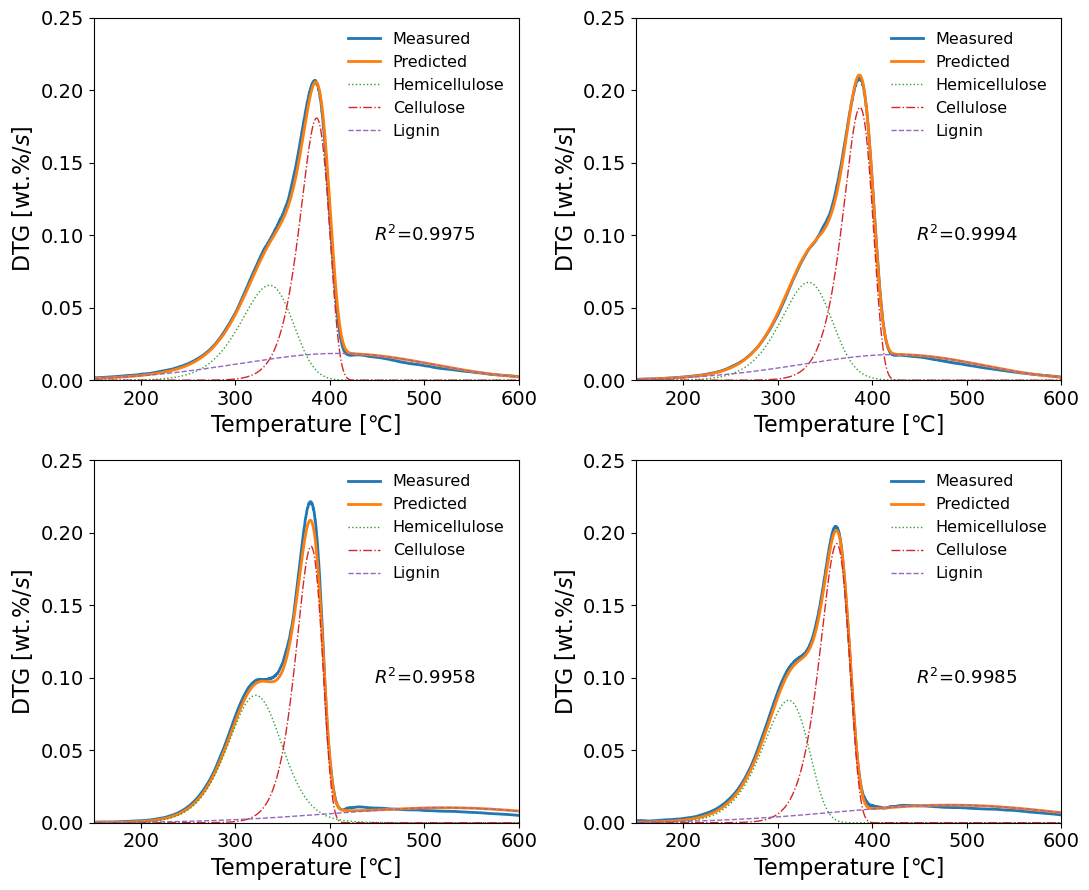

In [7]:
# Reproducing DTG curve generated by predicted kinetic parameters
DTG_pred_smp = np.zeros([SampleDTG_restored.shape[0], SampleDTG_restored.shape[1]]) 
DTG_H_smp = np.zeros_like(DTG_pred_smp)
DTG_C_smp = np.zeros_like(DTG_pred_smp)
DTG_L_smp = np.zeros_like(DTG_pred_smp)

fit_smp = np.zeros([SampleDTG_restored.shape[0]])
r2_DTG_smp = np.zeros([SampleDTG_restored.shape[0]])
R_u = 8.314   #J/mol-K
dt_test = np.zeros(SampleDTG_restored.shape[0])
dt_test[:SampleDTG_restored.shape[0]] = 0.2/(1/6)

for i in range(r2_DTG_smp.shape[0]):
    A_H = np.power(10, A_H_pred_smp[i])
    E_H = E_H_pred_smp[i]    #kJ/mol-K
    n_H = n_H_pred_smp[i]
    c_H = c_H_pred_smp[i]
    A_C = np.power(10, A_C_pred_smp[i])
    E_C = E_C_pred_smp[i]
    n_C=  1
    A_L = np.power(10, A_L_pred_smp[i])
    E_L = E_L_pred_smp[i]
    n_L = 1
    c_L = c_L_pred_smp[i]
    c_C = 1-c_H-c_L
    
    Temp =  423.15
    alpha_H = 0
    alpha_C = 0
    alpha_L = 0

    for j in range(SampleDTG_restored.shape[1]):
        DTG_H_smp[i, j] = A_H * np.exp(-E_H*1000/R_u/Temp)*np.power((1-alpha_H), n_H)   #Unit: 1/s
        DTG_C_smp[i, j] = A_C * np.exp(-E_C*1000/R_u/Temp)*np.power((1-alpha_C), n_C)  
        DTG_L_smp[i, j] = A_L * np.exp(-E_L*1000/R_u/Temp)*np.power((1-alpha_L), n_L)  

        alpha_H = alpha_H + DTG_H_smp[i, j]*dt_test[i]
        alpha_C = alpha_C + DTG_C_smp[i, j]*dt_test[i]
        alpha_L = alpha_L + DTG_L_smp[i, j]*dt_test[i]
        
        if alpha_H > 1:
            alpha_H = 1
        if alpha_C > 1:
            alpha_C = 1
        if alpha_L > 1:
            alpha_L = 1
        
        Temp = Temp + 0.2
        
    DTG_H_smp[i, :] *= c_H
    DTG_C_smp[i, :] *= c_C
    DTG_L_smp[i, :] *= c_L
    DTG_pred_smp[i, :] = DTG_H_smp[i, :] + DTG_C_smp[i, :] + DTG_L_smp[i, :]

    r2_DTG_smp[i] = r2_score(SampleDTG_restored[i, :], DTG_pred_smp[i, :])
    fit_smp[i] = fit_quality(SampleDTG_restored[i, :], DTG_pred_smp[i, :])

print(fit_smp)  

indices = [HC, PW, BW, WP]
labels = ['HC', 'PW', 'BW', 'WP']
titles = ['Measured', 'Predicted', 'Hemicellulose', 'Cellulose', 'Lignin']
styles = ['-', '-', ':', '-.', '--']
lw = [2, 2, 1, 1, 1]
fig, axs = plt.subplots(2, 2, figsize=(11, 9))

for i, idx in enumerate(indices):
    ax = axs[i//2, i%2]
    for label, style, line_width in zip(titles, styles, lw):
        if label == 'Measured':
            ax.plot(temp, SampleDTG_restored[idx, :]*100, label=label, linestyle=style, lw=line_width)
        elif label == 'Predicted':
            ax.plot(temp, DTG_pred_smp[idx, :]*100, label=label, linestyle=style, lw=line_width)
        elif label == 'Hemicellulose':
            ax.plot(temp, DTG_H_smp[idx, :]*100, label=label, linestyle=style, lw=line_width)
        elif label == 'Cellulose':
            ax.plot(temp, DTG_C_smp[idx, :]*100, label=label, linestyle=style, lw=line_width)
        elif label == 'Lignin':
            ax.plot(temp, DTG_L_smp[idx, :]*100, label=label, linestyle=style, lw=line_width)
    
    ax.set_ylim(0, 0.25)
    ax.set_xlim(150, 600)
    ax.text(500, 0.1, f'$R^2$={r2_DTG_smp[idx]:.4f}', ha='center', va='center', fontsize=13)
    ax.set_xlabel('Temperature [℃]', fontsize=16)
    ax.set_ylabel(f'DTG [wt.%/$s$]', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    ax.legend(loc='upper right', frameon=False, fontsize=11.5)

plt.tight_layout()
plt.show()